In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
#!/usr/bin/env python
# coding: utf-8
# 모델의 reproducibility를 위해 random seed를 고정함
seed_value = 743
print("Train with random seed", seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow.keras import backend as K

Train with random seed 743


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 그래프를 그리기 위한 matplotlib 및 기타 utility 라이브러리를 import함
import pickle
import joblib 
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
# matplotlib를 사용해 그래프를 그릴 때 사용할 글꼴을 설정함
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

In [4]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화에 사용할 MinMaxScaler import
from sklearn.metrics import mean_squared_error  # MSE 성능 지표를 계산하기 하기 위한 함수 import

# 모델을 구축하기 위한 keras 관련 함수 import
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [5]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [6]:
def data_transform(name,time_steps):
    data=pd.read_csv("../Merged_Data/{:s}.csv".format(name))
    
    print("column =",data.columns)
    
    if name.split("x")[-1]=='(Seasonal_Trend)':
        
        data=data.drop("time",axis=1)
        sequences=[]
        for i in range(len(data) - time_steps + 1):
            sequence = data[i:i+time_steps]
            sequences.append(sequence)
        return np.array(sequences)
    
    return np.array(data[23:])

In [7]:
train_x=data_transform('train_x(Seasonal_Trend)',24)
train_y=data_transform('train_y',24)
test_x=data_transform('test_x(Seasonal_Trend)',24)
test_y=data_transform('test_y',24)
valid_x=data_transform('valid_x(Seasonal_Trend)',24)
valid_y=data_transform('valid_y',24)

column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['time', 'in_pm10_min', 'in_pm10_max', 'in_voc_min',
       'in_pm10_Seasonal_Trend'],
      dtype='object')
column = Index(['Y_pm10'], dtype='object')


In [8]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(55204, 24, 4) (55204, 1)
(3045, 24, 4) (3045, 1)
(3046, 24, 4) (3046, 1)


In [9]:
def attention_3d_block(inputs, input_dim, single_attention_vector):
    """Feature attention block 정의"""
    time_steps = int(inputs.shape[1])
    # Attention weights 계산
    a = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)  # (batch_size, input_dim, time_step)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)  # (batch_size, input_dim)
        a = RepeatVector(time_steps)(a)  # (batch_size, input_dim, time_step)
    output_attention_mul = multiply([inputs, a], name='attention_mul')  # Attention weights 적용
    return output_attention_mul

In [10]:
def model_attention_applied_before_lstm(batch_size, time_step, feature_num, single_attention_vector):
    """Attention LSTM 모델 정의"""
    inputs = Input(shape=(time_step, feature_num))
    x = attention_3d_block(inputs, feature_num, single_attention_vector)
    x = LSTM(6, activation='tanh',
             stateful=False,
             return_sequences=True,
             kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.))(x)
    output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

    model = Model(inputs=[inputs], outputs=output)
    return model

In [11]:
# 하이퍼 파라미터 정의
batch_size = 4
look_back = 24
feature_num = 4
SINGLE_ATTENTION_VECTOR = True

# LSTM 모델을 생성하고 compile를 진행함
model = model_attention_applied_before_lstm(batch_size, look_back, feature_num, SINGLE_ATTENTION_VECTOR)
model.compile(loss='mean_squared_error', optimizer='adam')

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [12]:
# 모델 훈련 진행
# 훈련 과정의 손실값을 history 변수에 저장
history = model.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    batch_size=batch_size, epochs=100,
                    callbacks=[earlystopping],)

Epoch 1/100
13801/13801 [==============================] - 41s 3ms/step - loss: 0.0120 - val_loss: 0.0041
Epoch 2/100
13801/13801 [==============================] - 39s 3ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 3/100
13801/13801 [==============================] - 39s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 4/100
13801/13801 [==============================] - 39s 3ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/100
13801/13801 [==============================] - 40s 3ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 6/100
13801/13801 [==============================] - 42s 3ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/100
13801/13801 [==============================] - 40s 3ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 8/100
13801/13801 [==============================] - 40s 3ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/100
13801/13801 [==============================] - 41s 3ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/100
13801/13801 [====================

In [13]:
from tensorflow.python.keras.models import load_model

if not os.path.exists("./Saved_Model(Seasonal_Trend)/"):
    os.makedirs("./Saved_Model(Seasonal_Trend)/")
    
model.save('./Saved_Model(Seasonal_Trend)/Attention_LSTM(Early_Stopping).pt')

INFO:tensorflow:Assets written to: ./Saved_Model(Seasonal_Trend)/Attention_LSTM(Early_Stopping).pt\assets


INFO:tensorflow:Assets written to: ./Saved_Model(Seasonal_Trend)/Attention_LSTM(Early_Stopping).pt\assets


In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

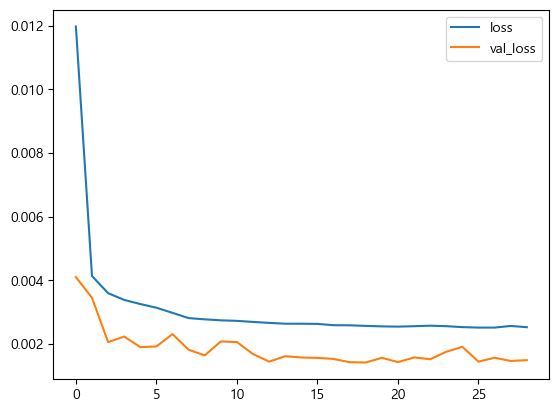

In [15]:
# train loss와 validation loss의 변화를 matplotlib를 사용해 시각화함
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

In [16]:
# 훈련한 모델을 사용해 예측을 진행함
train_predict = model.predict(train_x, batch_size)
valid_predict = model.predict(valid_x, batch_size)
test_predict = model.predict(test_x, batch_size)

In [17]:
import joblib
scaler=joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')
inv_train_y = scaler.inverse_transform(train_y)
inv_train_predict = scaler.inverse_transform(train_predict)
inv_valid_y = scaler.inverse_transform(valid_y)
inv_valid_predict = scaler.inverse_transform(valid_predict)
inv_test_y = scaler.inverse_transform(test_y)
inv_test_predict = scaler.inverse_transform(test_predict)

In [18]:
train_smape = Symmetric_mean_absolute_percentage_error(inv_train_y, inv_train_predict)
valid_smape = Symmetric_mean_absolute_percentage_error(inv_valid_y, inv_valid_predict)
test_smape = Symmetric_mean_absolute_percentage_error(inv_test_y, inv_test_predict)

In [19]:
print("Train SMAPE :" , train_smape)
print("Valid SMAPE :" , valid_smape)
print("Test SMAPE :" , test_smape)

Train SMAPE : 8.269637612181283
Valid SMAPE : 12.14350064074171
Test SMAPE : 5.494400670472272


In [20]:
def vizualization_self(train_term,name,test_y,pred_y):
    plt.figure(figsize=(32, 16))
    
    plt.plot(np.arange(train_term), test_y[:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[:train_term], color='blue', ls='--', lw=3, label='Prediction')
    
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Prediction Visualization({:s})'.format(name),fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

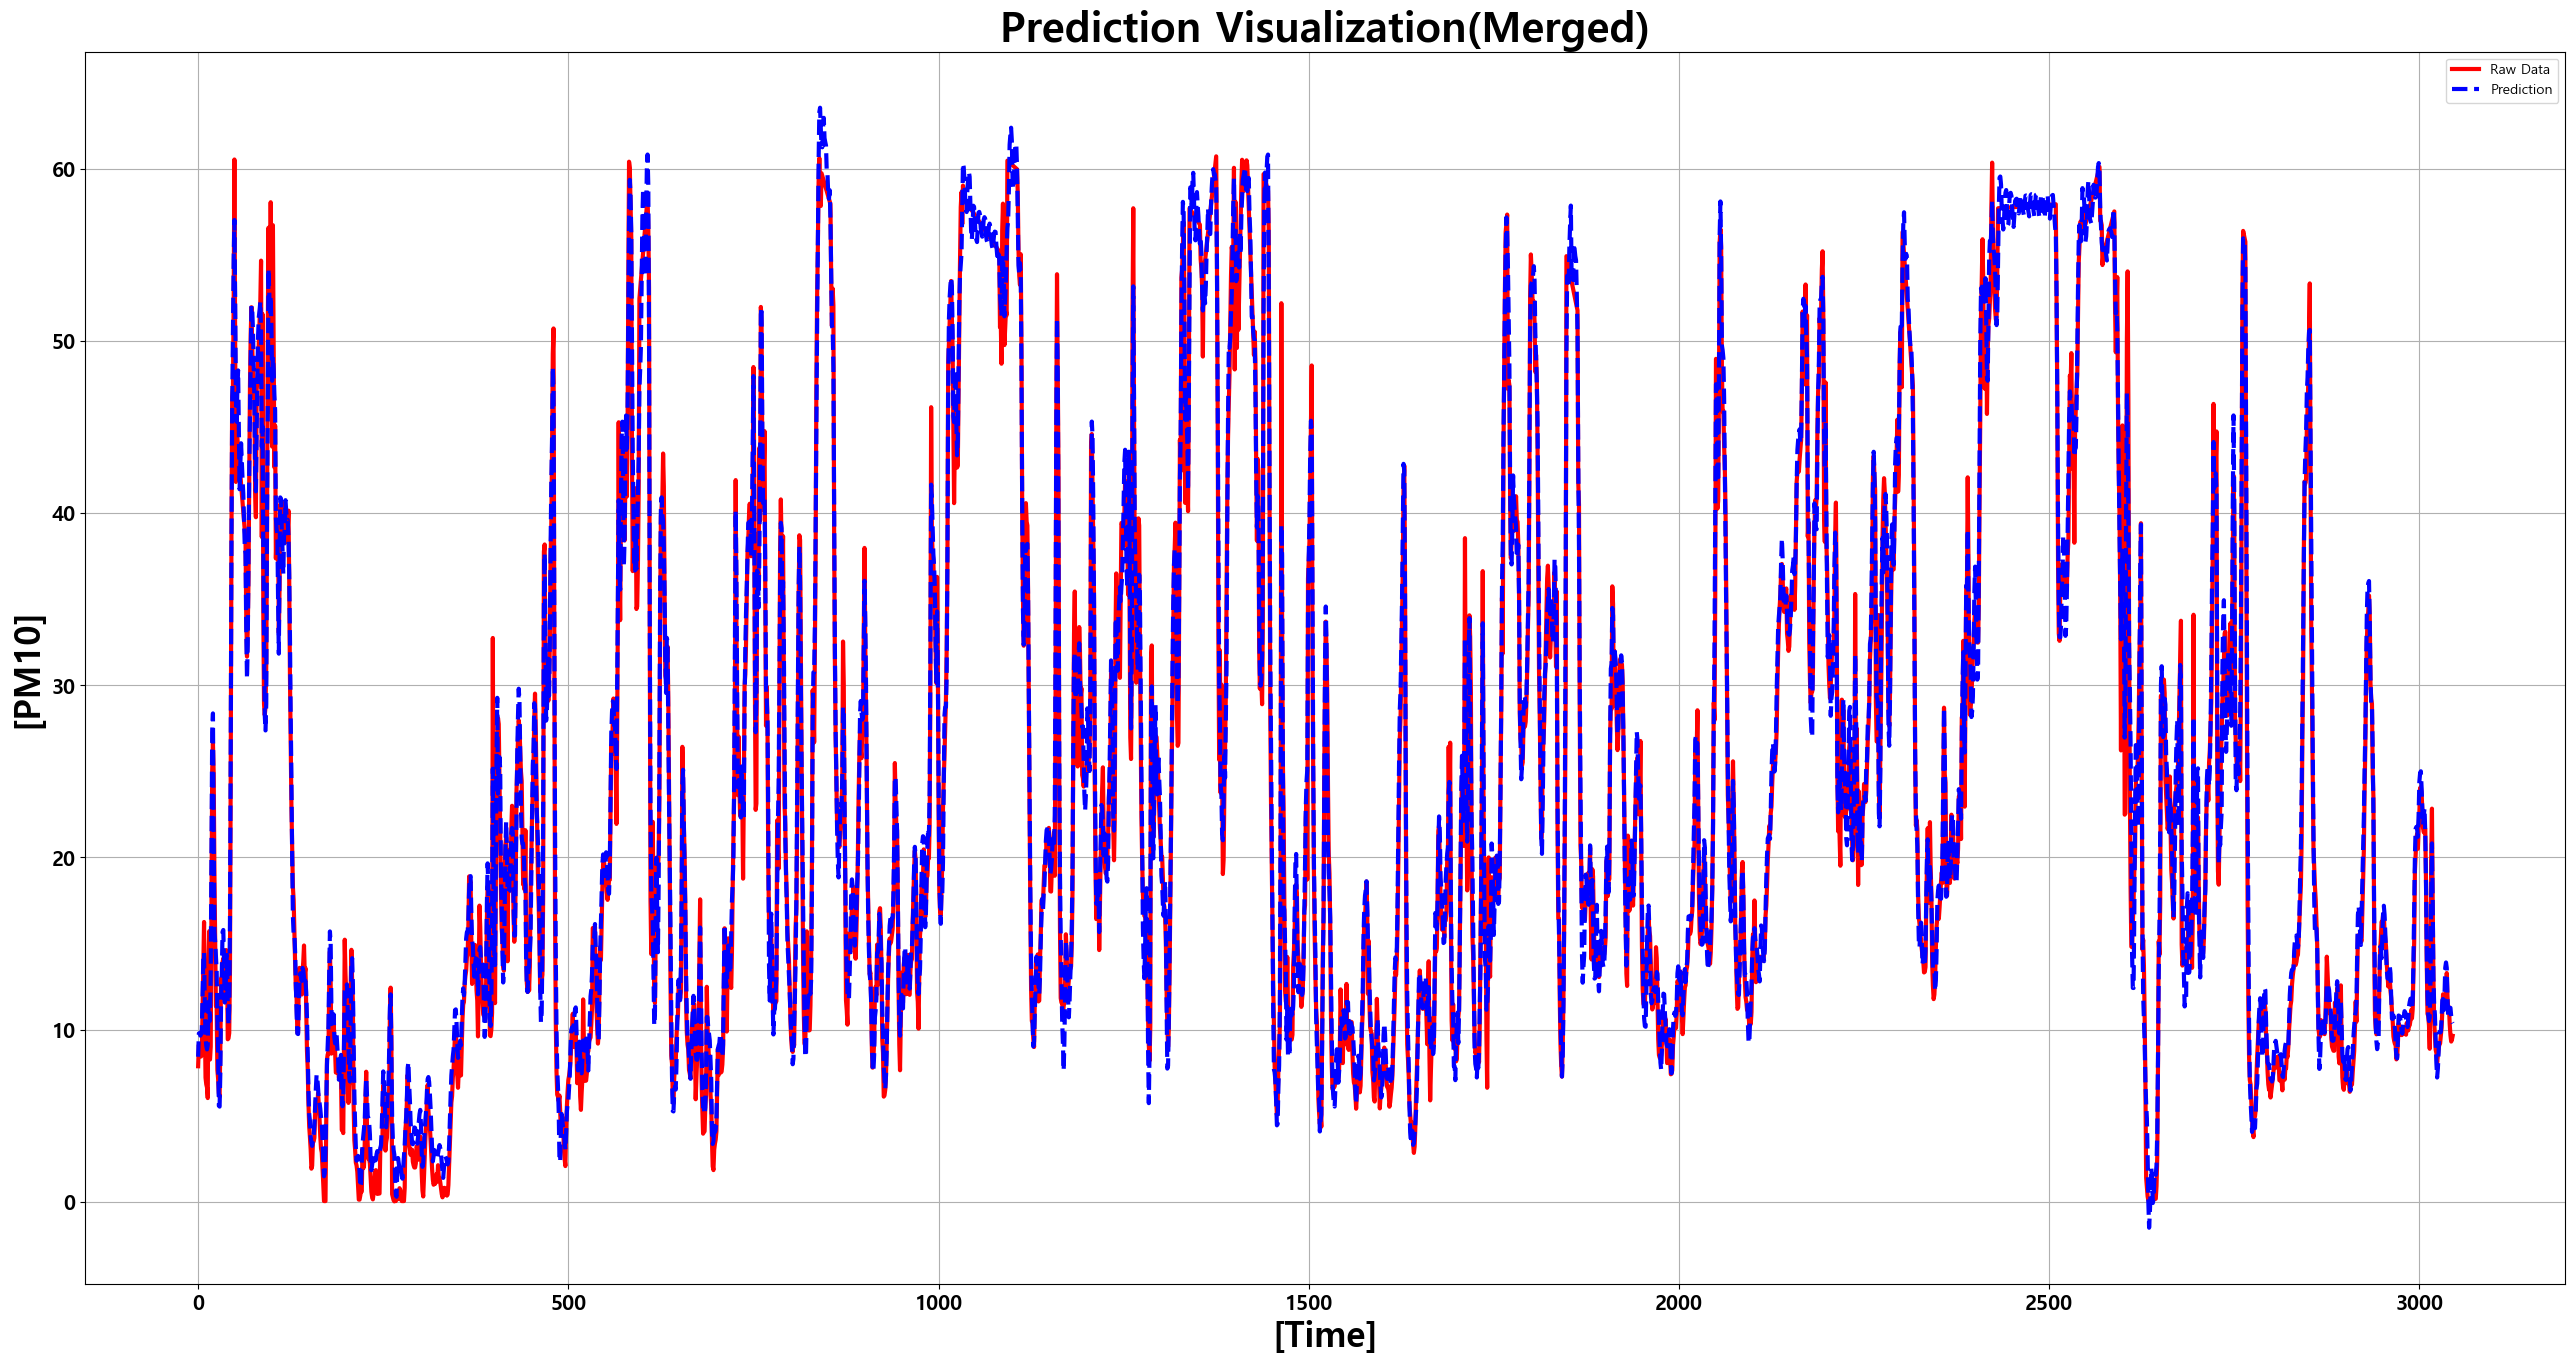

In [21]:
vizualization_self(len(inv_test_y),'Merged',inv_test_y,inv_test_predict)

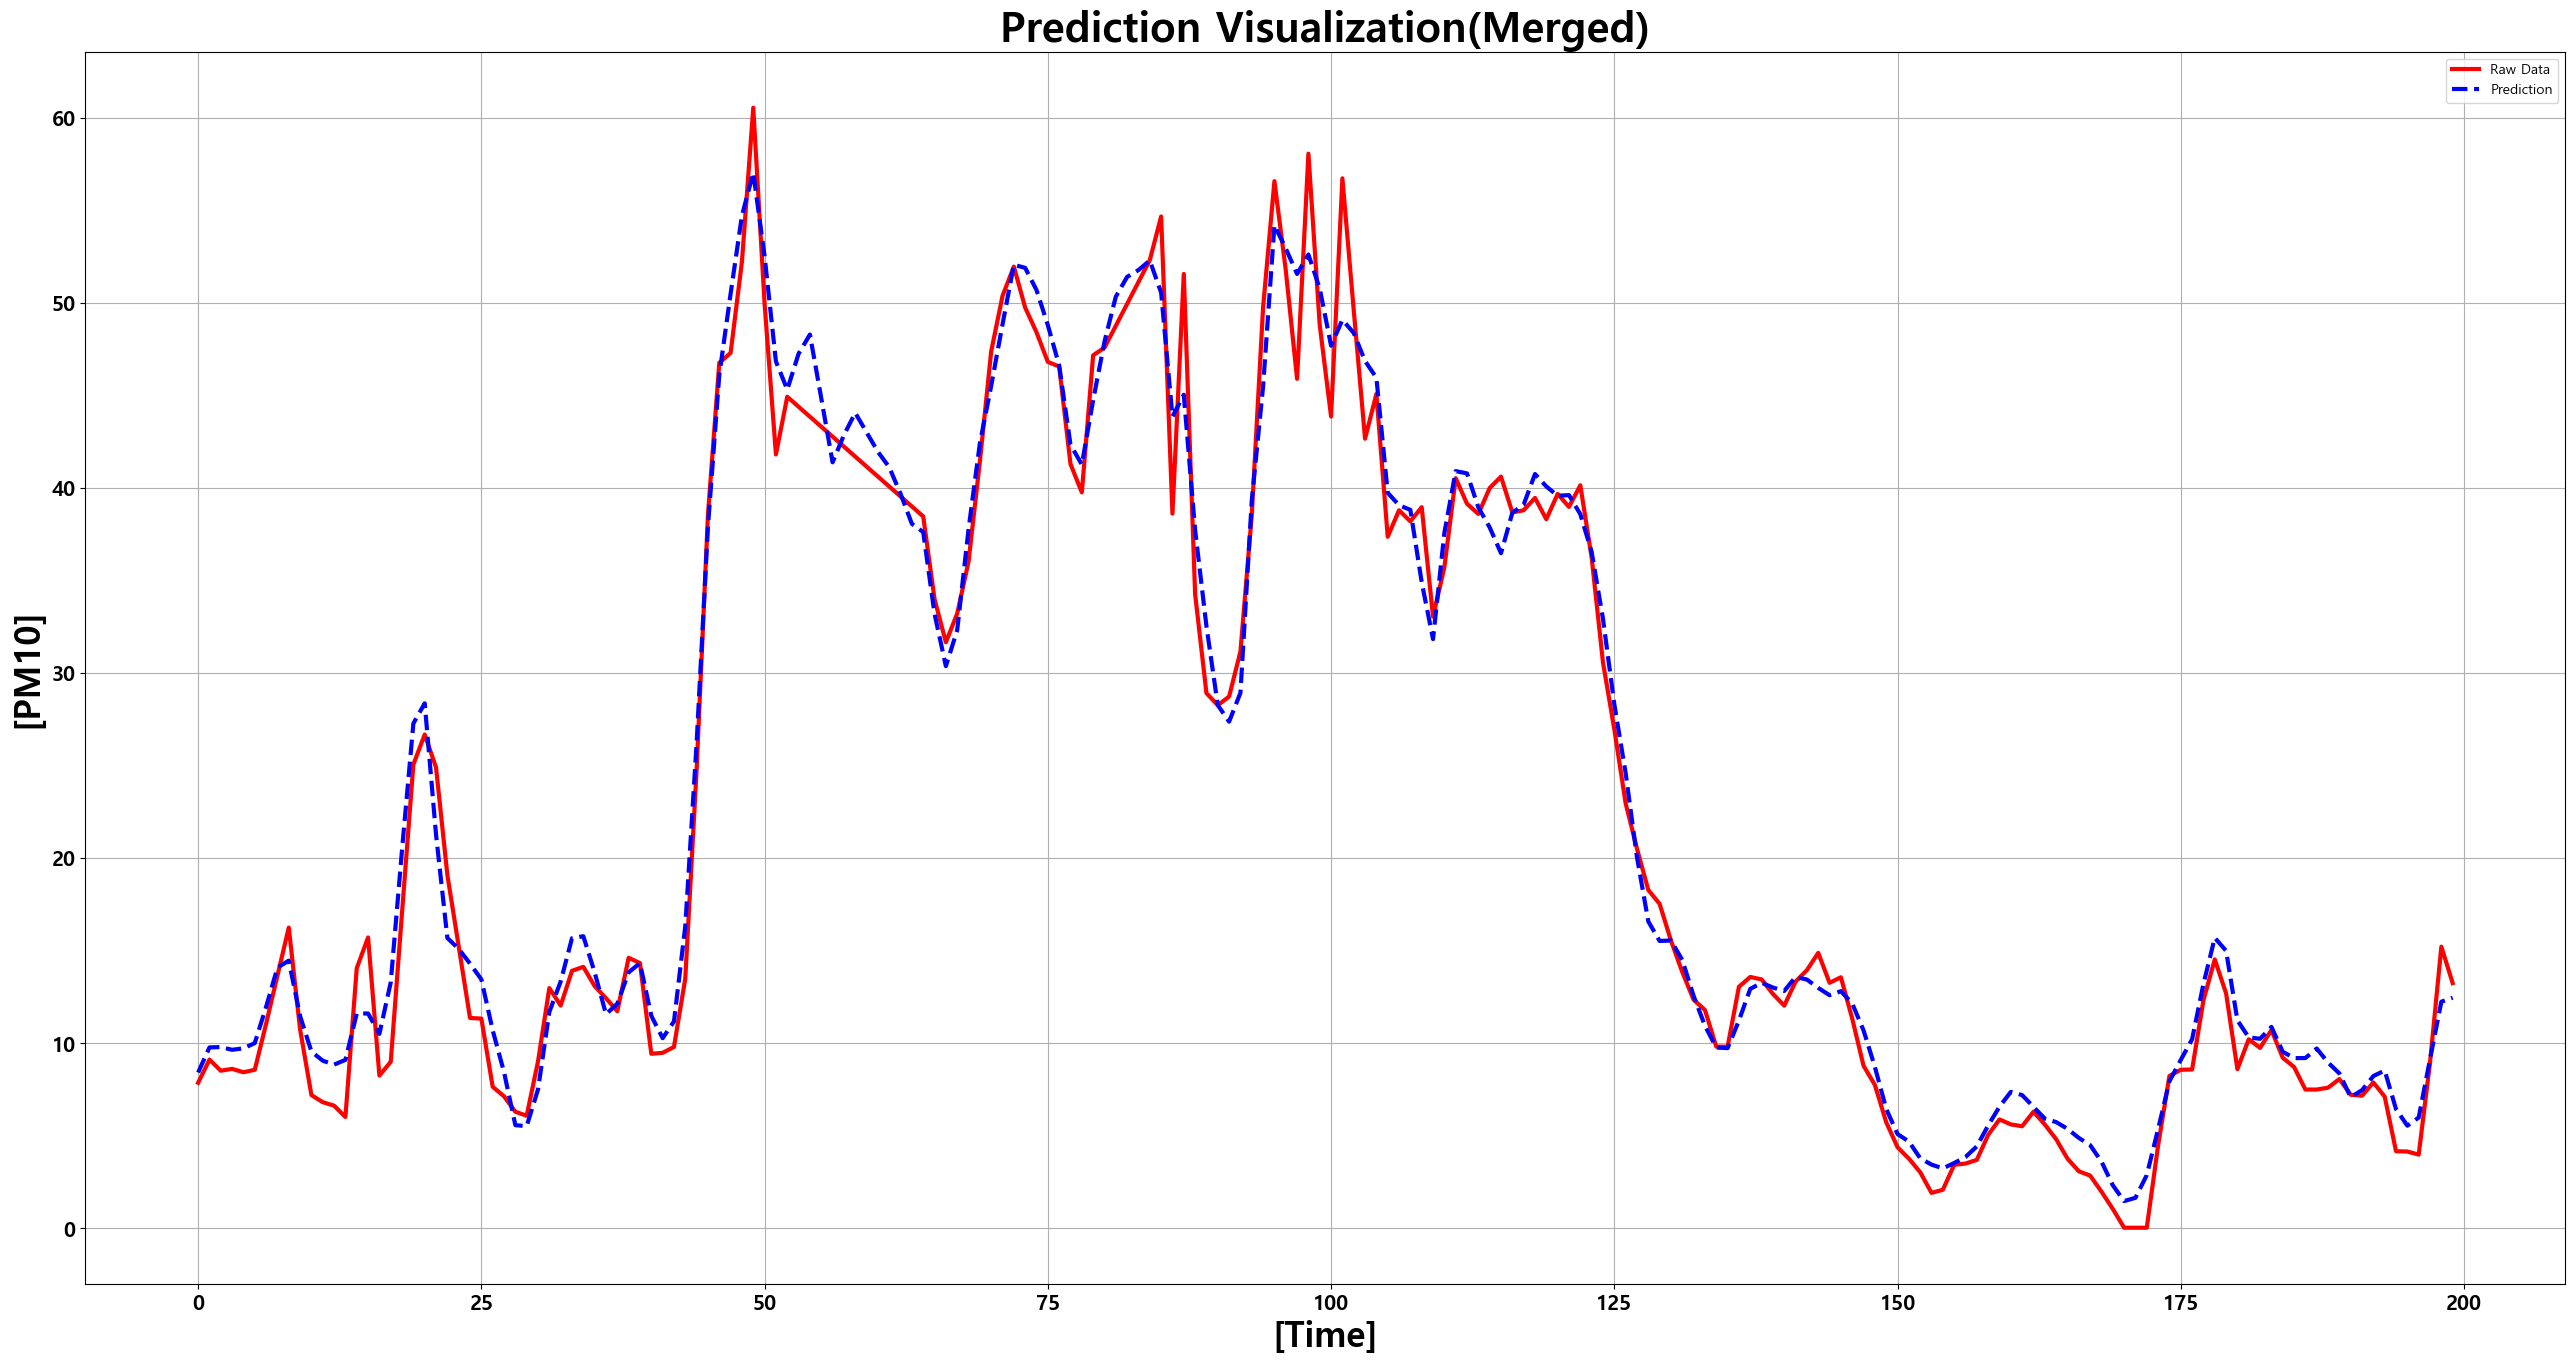

In [22]:
vizualization_self(200,'Merged',inv_test_y,inv_test_predict)